In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from models.tfkeras_resnets import build_single_block_resnet, build_resnet
from dataset_utils.tf_dataset_preprocessors_image_classification import UnpackImagesLabels, ConvertLabelsToOneHot, DecodeImages, ResizeWithPad, RandomFlipLeftRight, RandomCrop, Resize
from dataset_utils.tfrecord_dataset_creator import TFRecordDatasetCreator, get_tfrecord_paths

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam

print("TensorFlow version: {}".format(tf.__version__))

%matplotlib inline

TensorFlow version: 1.12.0


In [9]:
import tensorflow as tf

def add_mean_norm_summary(variable, scope):
  '''
  Attach a tf.summary to compute the l2 norm of the variable divided by its number
  of components.
  
  Arguments:
    variable (TensorFlow Variable): A TensorFlow Variable of any shape to which to
        add this summary operation. Must be a numerical data type.
  '''
  with tf.name_scope(scope):
    l2_norm = tf.norm(variable,
                      ord='euclidean',
                      axis=None,
                      name=None)
    mean_l2_norm = l2_norm / tf.to_float(tf.size(variable))
    return tf.summary.scalar('{}_mean_l2_norm'.format(scope), mean_l2_norm)

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import math_ops
import tensorflow.keras.backend as K

class AdamWithGradSummaries(Adam):
    
    def __init__(self, **kwargs):
        super(AdamWithGradSummaries, self).__init__(**kwargs)
        
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        
        # Add tf.summaries that compute the gradient norms.
        grad_summaries = []
        for grad, param in zip(grads, params):
            summary_name_scope = param.name.replace(':', '_') + '_gradient'
            grad_summaries.append(add_mean_norm_summary(grad, summary_name_scope))
        tf.summary.merge(grad_summaries, name='gradient_summaries')
        
        self.updates = [state_ops.assign_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (  # pylint: disable=g-no-augmented-assignment
                       1. / (1. + self.decay * math_ops.cast(self.iterations,
                                                             K.dtype(self.decay))))

        t = math_ops.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (
            K.sqrt(1. - math_ops.pow(self.beta_2, t)) /
            (1. - math_ops.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * math_ops.square(g)
            if self.amsgrad:
                vhat_t = math_ops.maximum(vhat, v_t)
                p_t = p - lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(state_ops.assign(vhat, vhat_t))
            else:
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(state_ops.assign(m, m_t))
            self.updates.append(state_ops.assign(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(state_ops.assign(p, new_p))
        return self.updates

In [15]:
class TensorBoardCustom(TensorBoard):
    def __init__(self,
                 update_freq=10,
                 **kwargs):
        super(TensorBoardCustom, self).__init__(**kwargs)
        if update_freq == 'batch':
            self.update_freq = 1
        else:
            self.update_freq = update_freq
        self._samples_seen = 0
        self._samples_seen_at_last_write = 0
        
    def _write_gradient_summaries(self, step):
        grad_summaries = tf.get_default_graph().get_tensor_by_name('gradient_summaries:0')
        self.writer.add_summary(grad_summaries, step)
        
    def on_batch_end(self, batch, logs=None):
        """Writes scalar summaries for metrics on every training batch."""
        # Don't output batch_size and batch number as Tensorboard summaries
        logs = logs or {}
        self._samples_seen += logs.get('size', 1)
        samples_seen_since = self._samples_seen - self._samples_seen_at_last_write
        if self.update_freq != 'epoch' and samples_seen_since >= self.update_freq:
            batch_logs = {('batch_' + k): v
                          for k, v in logs.items()
                          if k not in ['batch', 'size', 'num_steps']}
            self._write_gradient_summaries(step)
            self._write_custom_summaries(self._total_batches_seen, batch_logs)
            self._samples_seen_at_last_write = self._samples_seen
        self._total_batches_seen += 1
        
    def on_epoch_end(self, epoch, logs=None):
        """Checks if summary ops should run next epoch, logs scalar summaries."""

        # don't output batch_size and
        # batch number as Tensorboard summaries
        logs = {('epoch_' + k): v
                for k, v in logs.items()
                if k not in ['batch', 'size', 'num_steps']}
        if self.update_freq == 'epoch':
            step = epoch
        else:
            step = self._samples_seen
        self._write_custom_summaries(epoch, logs)

        # pop the histogram summary op after each epoch
        if self.histogram_freq:
            if self.merged in self.model.test_function.fetches:
                self.model.test_function.fetches.remove(self.merged)
            if self.merged in self.model.test_function.fetch_callbacks:
                self.model.test_function.fetch_callbacks.pop(self.merged)

        if self.embeddings_data is None and self.embeddings_freq:
            raise ValueError('To visualize embeddings, embeddings_data must '
                             'be provided.')

        if self.embeddings_freq and self.embeddings_data is not None:
            if epoch % self.embeddings_freq == 0:
                # We need a second forward-pass here because we're passing
                # the `embeddings_data` explicitly. This design allows to pass
                # arbitrary data as `embeddings_data` and results from the fact
                # that we need to know the size of the `tf.Variable`s which
                # hold the embeddings in `set_model`. At this point, however,
                # the `validation_data` is not yet set.

                embeddings_data = self.embeddings_data
                n_samples = embeddings_data[0].shape[0]
                i = 0
                while i < n_samples:
                    step = min(self.batch_size, n_samples - i)
                    batch = slice(i, i + step)

                    if isinstance(self.model.input, list):
                        feed_dict = {
                            model_input: embeddings_data[idx][batch]
                            for idx, model_input in enumerate(self.model.input)
                        }
                    else:
                        feed_dict = {self.model.input: embeddings_data[0][batch]}

                    feed_dict.update({self.batch_id: i, self.step: step})

                    if self.model.uses_learning_phase:
                        feed_dict[K.learning_phase()] = False

                    self.sess.run(self.assign_embeddings, feed_dict=feed_dict)
                    self.saver.save(self.sess,
                                    os.path.join(self.log_dir, 'keras_embedding.ckpt'),
                                    epoch)

                    i += self.batch_size

In [5]:
num_classes = 257
image_size = (224, 224, 3)

blocks_resnet50  = [3, 4,  6, 3]
blocks_resnet101 = [3, 4, 23, 3]
blocks_resnet152 = [3, 8, 36, 3]

In [6]:
tf.keras.backend.clear_session()

resnet50 = build_resnet(image_size=image_size,
                        kernel_type='regular',#'antisymmetric',
                        include_top=True,
                        num_classes=num_classes,
                        l2_regularization=0.0,
                        subtract_mean=127.5,
                        divide_by_stddev=127.5,
                        version=1,
                        preset='resnet50',
                        blocks_per_stage=[3, 4, 6, 3],
                        filters_per_block=[[64, 64, 256],
                                           [128, 128, 512],
                                           [256, 256, 1024],
                                           [512, 512, 2048]],
                        use_batch_norm=True)

In [3]:
tf.keras.backend.clear_session()

simplified_resnet_antisymmetric = build_single_block_resnet(image_size=image_size,
                                                            kernel_type='antisymmetric',
                                                            blocks_per_stage=[2,2,2,2],
                                                            filters_per_block=[32, 64, 128, 256],
                                                            num_classes=10,
                                                            use_batch_norm=False,
                                                            use_max_pooling=[True, True, True, True],
                                                            subtract_mean=127.5,
                                                            divide_by_stddev=127.5,
                                                            include_top=True)

In [5]:
for layer in resnet50.layers:
    print('{}:\t\t{}'.format(layer.name, layer.output.shape))

input_1:		(?, 224, 224, 3)
identity_layer:		(?, 224, 224, 3)
input_mean_normalization:		(?, 224, 224, 3)
input_stddev_normalization:		(?, 224, 224, 3)
conv1_pad:		(?, 230, 230, 3)
conv1:		(?, 112, 112, 64)
bn_conv1:		(?, 112, 112, 64)
activation:		(?, 112, 112, 64)
pool1_pad:		(?, 114, 114, 64)
stage1_pooling:		(?, 56, 56, 64)
res2_0_branch2a:		(?, 56, 56, 64)
bn2_0_branch2a:		(?, 56, 56, 64)
activation_1:		(?, 56, 56, 64)
res2_0_branch2b:		(?, 56, 56, 64)
bn2_0_branch2b:		(?, 56, 56, 64)
activation_2:		(?, 56, 56, 64)
res2_0_branch1:		(?, 56, 56, 256)
res2_0_branch2c:		(?, 56, 56, 256)
bn2_0_branch1:		(?, 56, 56, 256)
add:		(?, 56, 56, 256)
activation_3:		(?, 56, 56, 256)
res2_1_branch2a:		(?, 56, 56, 64)
bn2_1_branch2a:		(?, 56, 56, 64)
activation_4:		(?, 56, 56, 64)
res2_1_branch2b:		(?, 56, 56, 64)
bn2_1_branch2b:		(?, 56, 56, 64)
activation_5:		(?, 56, 56, 64)
res2_1_branch2c:		(?, 56, 56, 256)
add_1:		(?, 56, 56, 256)
activation_6:		(?, 56, 56, 256)
res2_2_branch2a:		(?, 56, 56, 

In [7]:
tfrecords_directory = '/pierluigiferrari/datasets/Caltech256'

feature_schema = {'image': tf.FixedLenFeature([], tf.string),
                  'filename': tf.FixedLenFeature([], tf.string),
                  'label': tf.FixedLenFeature([], tf.int64)}

unpack_images_labels = UnpackImagesLabels()
decode_images = DecodeImages(channels=3)
random_crop = RandomCrop(aspect_ratio=1,
                         scale=1.0,
                         channels=3,
                         num_parallel_calls=None)
resize = Resize(target_size=image_size[:2])
resize_with_pad = ResizeWithPad(target_size=image_size[:2])
random_flip_left_right = RandomFlipLeftRight()
convert_labels_to_one_hot = ConvertLabelsToOneHot(num_classes=257)

preprocessors = [unpack_images_labels,
                 decode_images,
                 random_flip_left_right,
                 resize_with_pad,
                 convert_labels_to_one_hot]

tfrecord_dataset_creator = TFRecordDatasetCreator(tfrecord_paths=get_tfrecord_paths(directory=tfrecords_directory, extension='tfrecord'),
                                                  feature_schema=feature_schema,
                                                  batch_size=16,
                                                  preprocessors=preprocessors,
                                                  num_epochs=None,
                                                  shuffle=True,
                                                  shuffle_buffer_size=1000,
                                                  num_parallel_reads=None,
                                                  num_parallel_calls=None)

dataset = tfrecord_dataset_creator.create_dataset()

In [5]:
iterator = dataset.make_one_shot_iterator()
batch = iterator.get_next()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

2
(16, 224, 224, 3)
(16, 257)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


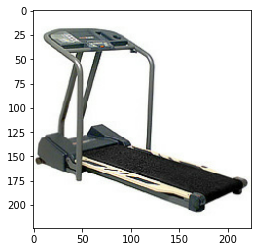

In [7]:
samples = sess.run(batch)
print(len(samples))
print(samples[0].shape)
print(samples[1].shape)
print(samples[1][0])
plt.imshow(samples[0][0].astype(np.uint8))

In [17]:
adam = Adam(lr=0.001)
adam_with_grad_norm = AdamWithGradSummaries(lr=0.001)

resnet50.compile(optimizer=adam_with_grad_norm,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

tensor_board = TensorBoard(log_dir='./local/',
                           histogram_freq=1,
                           batch_size=32,
                           write_graph=True,
                           write_grads=True,
                           write_images=False)

tensor_board_custom = TensorBoardCustom(log_dir='./local/',
                                        histogram_freq=0,
                                        batch_size=32,
                                        write_graph=True,
                                        write_grads=False,
                                        write_images=False,
                                        update_freq=10)

callbacks = [tensor_board_custom]

history = resnet50.fit(dataset,
                       epochs=1,
                       verbose=1,
                       callbacks=callbacks,
                       initial_epoch=0,
                       steps_per_epoch=1000)

results = resnet50.evaluate(dataset, steps=1000)

print(results)

Epoch 1/1
   4/1000 [..............................] - ETA: 1:50:28 - loss: 9.7340 - acc: 0.0000e+00

KeyboardInterrupt: 

In [5]:
simplified_resnet_antisymmetric.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

tensor_board = TensorBoard(log_dir='./local/',
                           histogram_freq=1,
                           batch_size=32,
                           write_graph=True,
                           write_grads=True,
                           write_images=False)

callbacks = [tensor_board]

history = simplified_resnet_antisymmetric.fit(dataset,
                       epochs=1,
                       verbose=1,
                       callbacks=None,
                       initial_epoch=0,
                       steps_per_epoch=20)

results = simplified_resnet_antisymmetric.evaluate(dataset, steps=20)

Epoch 1/1
20/20 [==============================] - 3s 144ms/step


In [8]:
print(history.history['loss'])
print(results)

[nan]
[nan, 0.0]


In [6]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape)
print(y_train[0])

(60000, 28, 28, 1)
5


In [5]:
simplified_resnet_antisymmetric.compile(optimizer='adam',
                                        loss='sparse_categorical_crossentropy',
                                        metrics=['accuracy'])

simplified_resnet_antisymmetric.fit(x_train, y_train, batch_size=32, epochs=1)
simplified_resnet_antisymmetric.evaluate(x_test, y_test)

Epoch 1/1
10000/10000 [==============================] - 4s 449us/step


[14.49177936706543, 0.1009]

In [11]:
i = np.random.randint(x_train.shape[0])

y_pred = simplified_resnet_antisymmetric.predict([[x_train[i]]])

np.set_printoptions(suppress=True, precision=4)

print('image name:\t{}'.format(i))
print('ground truth:\t{}'.format(y_train[i]))
print()
print('prediction:')
for k in range(len(y_pred[0])):
    print('{}:\t{:.2f}'.format(k, y_pred[0][k]))

image name:	55428
ground truth:	5

prediction:
0:	0.00
1:	0.00
2:	0.00
3:	0.00
4:	0.00
5:	0.99
6:	0.00
7:	0.00
8:	0.01
9:	0.00


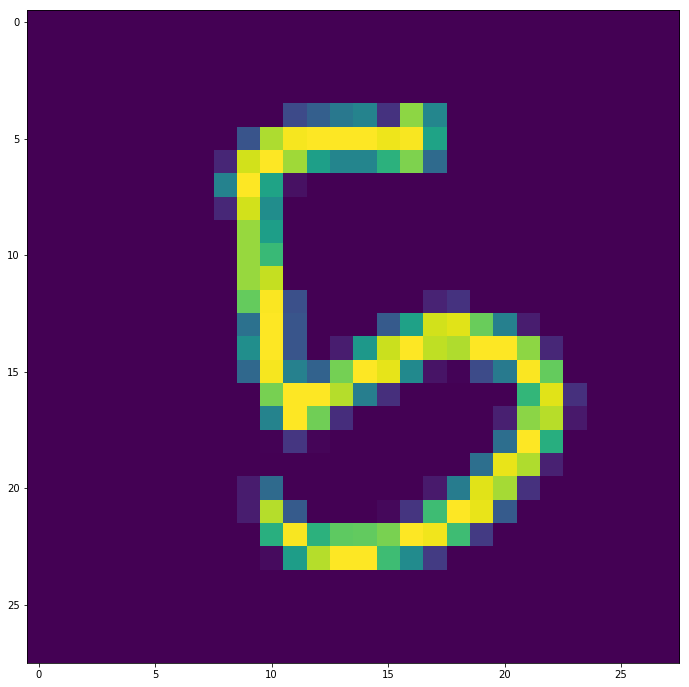

In [12]:
plt.figure(figsize=(20,12))
plt.imshow(np.squeeze(x_train[i]))

In [13]:
res2a_branch2 = simplified_resnet_antisymmetric.get_layer('res2a_branch2')
res2d_branch2 = simplified_resnet_antisymmetric.get_layer('res2d_branch2')

res2a_branch2_kernel = res2a_branch2.get_kernel()
res2d_branch2_kernel = res2d_branch2.get_kernel()

print(res2a_branch2_kernel[:,:,1,1])
print()
print(res2d_branch2_kernel[:,:,1,1])

[[ 0.0452 -0.0144  0.0407]
 [ 0.1174  0.     -0.1174]
 [-0.0407  0.0144 -0.0452]]

[[-0.002  -0.0845 -0.1493]
 [-0.0401  0.      0.0401]
 [ 0.1493  0.0845  0.002 ]]


In [30]:
for i in range(ord('a'), ord('a')+0):
    print('hello')

In [25]:
print(ord('a'))

97
